In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any

import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import time
import matplotlib.pyplot as plt

In [2]:
class EncoderRNN(nn.Module):
    """Encoder Network."""
    def __init__(self,
                 input_size: int = 2,
                 embedding_size: int = 8,
                 hidden_size: int = 16):
        """Initialize the encoder network.
        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)

    def forward(self, x: torch.FloatTensor, hidden: Any) -> Any:
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            hidden: final hidden 
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        return hidden


In [3]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=8, hidden_size=16, output_size=2):
        """Initialize the decoder network.
        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [4]:
train_set = np.load("train_set2.npy")
train_target = np.load("train_target2.npy")
l = train_set.shape[0]
train_set.shape,train_target.shape

((208272, 2, 19), (208272, 2, 30))

In [5]:
#train_set = train_set.transpose(0,2,1)
#train_target = train_target.transpose(0,2,1)
#train_set.shape,train_target.shape

train_data = np.concatenate((train_set,train_target),axis = 2)
train_data.shape

(208272, 2, 49)

In [6]:
toTensor_sig = torch.tensor(train_data[0:208272:10]*10)
train_data_set = TensorDataset(toTensor_sig)

In [7]:
#set up the train parameters
batch_size = 1000 #600 #500
epoch = 500
lr = 0.0001

encoder = EncoderRNN()
decoder = DecoderRNN()
criterion = nn.MSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
tr_data_loader = DataLoader(train_data_set,batch_size = batch_size, shuffle = True)
loss_overall = []

In [ ]:

start = time.time()

for i in range(epoch):
    print("============================================")
    print("epoch: ", i+1)
    loss_batch = 0
    cur_MSE = 0
    for (idx,data) in enumerate(tr_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        #print(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]
        #print(decoder_input.shape)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),
                                                     decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output
            #print(decoder_output)

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))
            

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
            
        
        #loss = criterion(decoder_outputs, target.type(torch.FloatTensor))
        # Get average loss for pred_len
        #loss = (loss/batch_size).type(torch.FloatTensor)
        #cur_MSE += loss
        #print(loss.dtype)
        loss = loss/20
        loss_batch+=loss
        #print(loss)
        loss.backward()
        encoder_optimizer.step()
        #print("decoder")
        decoder_optimizer.step()
        #print(decoder_outputs)
        #print(target)
        #break
    #loss_overall.append(cur_MSE)
    print(loss_batch/batch_size)    #average loss per batch
    loss_overall.append(loss_batch/batch_size)

torch.save(encoder,'trained_encoder_1125.pth')
torch.save(decoder,'trained_decoder_1125.pth')

end = time.time()

epoch:  1
tensor(0.6315, grad_fn=<DivBackward0>)
epoch:  2
tensor(0.6305, grad_fn=<DivBackward0>)
epoch:  3
tensor(0.6293, grad_fn=<DivBackward0>)
epoch:  4
tensor(0.6282, grad_fn=<DivBackward0>)
epoch:  5
tensor(0.6268, grad_fn=<DivBackward0>)
epoch:  6
tensor(0.6259, grad_fn=<DivBackward0>)
epoch:  7
tensor(0.6244, grad_fn=<DivBackward0>)
epoch:  8
tensor(0.6224, grad_fn=<DivBackward0>)
epoch:  9
tensor(0.6208, grad_fn=<DivBackward0>)
epoch:  10
tensor(0.6185, grad_fn=<DivBackward0>)
epoch:  11
tensor(0.6160, grad_fn=<DivBackward0>)
epoch:  12
tensor(0.6127, grad_fn=<DivBackward0>)
epoch:  13
tensor(0.6092, grad_fn=<DivBackward0>)
epoch:  14


In [13]:
torch.save(encoder,'trained_encoder8.pth')
torch.save(decoder,'trained_decoder8.pth')

## Print learning curve

In [ ]:

for i in range(len(loss_overall)):
    loss_overall[i] = loss_overall[i].detach().numpy()


In [ ]:
print(loss_overall)
plt.plot(loss_overall)
    

In [ ]:

print("training time: ", end - start)

# Test

## Test on Training Dataset

In [15]:
l = train_data[0:208272:100].shape[0]
to_tensor_test = torch.tensor(train_data[0:208272:10]*10)
test_data_set = TensorDataset(to_tensor_test)
te_data_loader = DataLoader(test_data_set,batch_size = batch_size, shuffle = False)


encoder = torch.load("trained_encoder8.pth")
decoder = torch.load("trained_decoder8.pth")


ground_truth = []
predict = []
print("ok")

ok


In [16]:
for (idx,data) in enumerate(te_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        ground_truth.append(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),
                                                     decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))
            

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
        predict.append(decoder_outputs)
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [17]:
ground_truth[0].shape, predict[0].shape, len(ground_truth), len(predict),ground_truth[0][15,:,:][0].shape



(torch.Size([1000, 2, 20]),
 torch.Size([1000, 2, 20]),
 21,
 21,
 torch.Size([20]))

In [18]:
print(train_data[0:208272:10][0][0,29:])  #first batch first trajectory
print("=================")
print(ground_truth[0][0,0,:])  #first batch first trajectory
print("=================")
print(predict[0][0,0,:])
#print(predict[0][30,:,:])

[0.05380608 0.05022216 0.04932667 0.04808149 0.05323355 0.04701837
 0.04797148 0.05152708 0.04672548 0.04612165 0.04512323 0.04741597
 0.04259974 0.04180918 0.04047923 0.0398205  0.03867161 0.04116073
 0.03618091 0.03602675]
tensor([0.5381, 0.5022, 0.4933, 0.4808, 0.5323, 0.4702, 0.4797, 0.5153, 0.4673,
        0.4612, 0.4512, 0.4742, 0.4260, 0.4181, 0.4048, 0.3982, 0.3867, 0.4116,
        0.3618, 0.3603], dtype=torch.float64)
tensor([-0.3164, -0.0571, -0.0170, -0.0115, -0.0107, -0.0106, -0.0106, -0.0106,
        -0.0106, -0.0106, -0.0106, -0.0106, -0.0106, -0.0106, -0.0106, -0.0104,
        -0.0095, -0.0025,  0.0428,  0.2114], grad_fn=<SliceBackward0>)


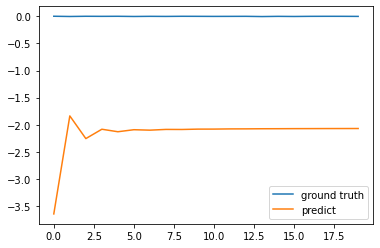

In [19]:
plt.plot(ground_truth[0][28,:,:][1].detach().numpy(),label = "ground truth")
plt.plot(predict[0][28,:,:][1].detach().numpy(), label = "predict")
plt.legend()


In [20]:
trajectory = np.load("trajectory_train.npy")[0:208272:100]

(2083, 2, 50)


array([[3840.38026748, 3840.76168095, 3841.04545339, 3841.33687289,
        3841.66647875, 3841.96974797, 3842.28210721, 3842.59442629,
        3842.94835477, 3843.27626787, 3843.64428733, 3843.9864728 ,
        3844.36880395, 3844.68747638, 3845.08515908, 3845.49356624,
        3845.83150934, 3846.25823055, 3846.65449224, 3847.14115706,
        3847.51567294, 3847.97445246, 3848.40632433, 3848.84079175,
        3849.32652167, 3849.77572298, 3850.27740457, 3850.64665649,
        3851.16016988, 3851.63396889, 3852.11179148, 3852.59469834,
        3853.08422102, 3853.63307262, 3854.13932841, 3854.70670282,
        3855.2281618 , 3855.75653559, 3856.34727692, 3856.94229808,
        3857.43535533, 3858.04372322, 3858.6036512 , 3859.16591865,
        3859.7310933 , 3860.30404809, 3860.93284813, 3861.5098939 ,
        3862.1546132 , 3862.74178006],
       [2345.93018682, 2346.29921357, 2346.5617862 , 2346.83232619,
        2347.13754923, 2347.41983518, 2347.71169469, 2348.00372922,
        2

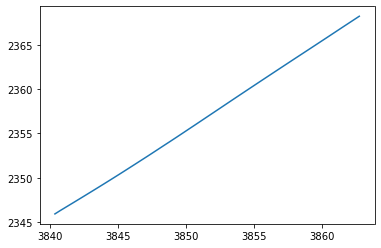

In [21]:
print(trajectory.shape)
plt.plot(trajectory[28][0],trajectory[28][1])
trajectory[28]

In [22]:
position = trajectory[28,:,29]
obs = trajectory[28,:,0:29]
predict_tr = np.zeros((2,50))
predict_tr[:,0:29] = obs
predict_tr[0],obs

(array([3840.38026748, 3840.76168095, 3841.04545339, 3841.33687289,
        3841.66647875, 3841.96974797, 3842.28210721, 3842.59442629,
        3842.94835477, 3843.27626787, 3843.64428733, 3843.9864728 ,
        3844.36880395, 3844.68747638, 3845.08515908, 3845.49356624,
        3845.83150934, 3846.25823055, 3846.65449224, 3847.14115706,
        3847.51567294, 3847.97445246, 3848.40632433, 3848.84079175,
        3849.32652167, 3849.77572298, 3850.27740457, 3850.64665649,
        3851.16016988,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ]),
 array([[3840.38026748, 3840.76168095, 3841.04545339, 3841.33687289,
         3841.66647875, 3841.96974797, 3842.28210721, 3842.59442629,
      

In [23]:
"""
[-0.1085,  0.0399,  0.2210,  0.4163,  0.5873,  0.7096,  0.7858,  0.8328,
         0.8615,  0.8791,  0.8900,  0.8968,  0.9011,  0.9038,  0.9054,  0.9064,
         0.9070,  0.9073,  0.9074,  0.9074]"""


for i in range(29,49):
    print(predict_tr[0][i-1]+predict[0][28,0,i-29].detach().numpy())
    #print(p(predict_tr[1][i-1]+predict[0][28,1,i-29].detach().numpy()))
    #print(predict[0][28,0,i-29])
    predict_tr[0][i] = (predict_tr[0][i-1]+predict[0][28,0,i-29].detach().numpy()/10)
    predict_tr[1][i] = (predict_tr[1][i-1]+predict[0][28,1,i-29].detach().numpy()/10)


3849.160412111542
3848.5777575876923
3847.833999791405
3847.9738050368046
3847.6404230740286
3847.471799340508
3847.2114146139834
3846.9962644961092
3846.751862015984
3846.5233561661457
3846.2832682755206
3846.0496896412587
3845.8108911183094
3845.5750253823016
3845.33659769561
3845.0995746996614
3844.8612167742463
3844.62355641391
3844.3851707365725
3844.147138228676


In [24]:
predict_tr[0][29:], (trajectory[28][0][28:]), train_data[0:208272:100][28][1][29:]

(array([3850.9601941 , 3850.72195045, 3850.43315538, 3850.18722035,
        3849.93254062, 3849.68646649, 3849.43896131, 3849.19469162,
        3848.95040866, 3848.70770341, 3848.4652599 , 3848.22370287,
        3847.9824217 , 3847.74168207, 3847.50117363, 3847.26101374,
        3847.02103404, 3846.78128628, 3846.54167472, 3846.30222107,
           0.        ]),
 array([3463.77534597, 3463.79121176, 3463.80222967, 3463.80299179,
        3463.80189206, 3463.80061932, 3463.79938925, 3463.80710756,
        3463.80393689, 3463.8073403 , 3463.80785434, 3463.80865627,
        3463.80889491, 3463.80643614, 3463.81027401, 3463.811218  ,
        3463.81178596, 3463.80967154, 3463.81040509, 3463.81119927,
        3463.81149049, 3463.81223609]),
 array([0.48992739, 0.49555883, 0.50437801, 0.56326129, 0.51661456,
        0.57876023, 0.53103911, 0.53665948, 0.59835222, 0.60208225,
        0.49794372, 0.61383797, 0.56135778, 0.56550758, 0.56948656,
        0.57722959, 0.63702269, 0.5860252 , 0.64820

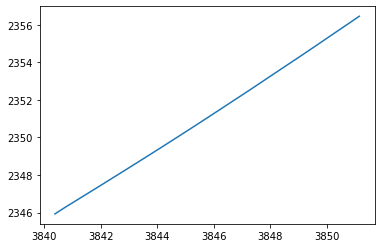

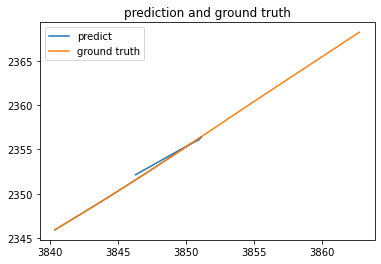

In [25]:

plt.figure()
plt.plot(obs[0],obs[1])
plt.figure()
plt.title("prediction and ground truth")
plt.plot(predict_tr[0][0:49],predict_tr[1][0:49],label = "predict") #,predict_tr[1][0:49]
#plt.figure()
plt.plot(trajectory[28][0],trajectory[28][1],label = "ground truth")    #,trajectory[28][1]
plt.legend()

In [ ]:
predict_tr

In [ ]:
np.save("sccc.npy",np.ones(1000))